In [114]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import datetime
%matplotlib inline

In [2]:
#create a function that pass a df and return a df with dummy data df
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    #df_num = df.select_dtypes(exclude = ['object'])
    #df_non_cat = df.drop(columns = cat_cols) 
    #df_dummies = pd.get_dummies(df[cat_cols], prefix= cat_cols, prefix_sep='_', dummy_na = dummy_na, drop_first = True)
    #df = pd.concat([df_non_cat, df_dummies], axis = 1)
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    

    return df

In [3]:
# create a function that generate predictive model
def clean_fit_linear_mod(df, response_col,test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    df = df.dropna(subset=[response_col])
    df = df.dropna(axis=1, how='all')
    #no need :num_cols = df.select_dtypes(exclude=['object']).columns # select all numeric columns
    # because create_dummy_df will drop all category data
    #df_new = create_dummy_df(df, cat_cols, dummy_na)
    df_new = df.apply(lambda col: col.fillna(col.mean()), axis = 0) # fill the mean to numeric columns
    
    
    X = df_new.drop(response_col, axis=1)
    y = df_new[response_col]
    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train,y_train)
    train_pred = lm_model.predict(X_train)
    test_pred=lm_model.predict(X_test)
    train_score = r2_score(y_train, train_pred)
    test_score = r2_score(y_test, test_pred)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

3 Business question to consider
1. How the listing prices flunctuate throughout the year?
2. What are the top amenities that are favored by the customers?
3. What are the features that highly influnce the prices? Can we predict the prices based on these features?
4. What neighbors have top reviews? What common features do they have?


In [4]:
#read data
!pwd
listings = pd.read_csv('/users/jxu/study/SeattleAirbnbOpenData/listings.csv')

/Users/jxu/jupyter


In [5]:
calendar = pd.read_csv('/users/jxu/study/SeattleAirbnbOpenData/calendar.csv')
listings = pd.read_csv('/users/jxu/study/SeattleAirbnbOpenData/listings.csv')
reviews = pd.read_csv('/users/jxu/study/SeattleAirbnbOpenData/reviews.csv')
calendar.dropna()['date'].max(),calendar.dropna()['date'].min()

('2017-01-02', '2016-01-04')

In [6]:
listings.describe()
#print(reviews.head())

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [7]:
#discover calendar data
print(calendar.shape)
calendar.describe()
calendar.head(1000)
#calendar.info()
#type(calendar['date'][0])
calendar.loc[calendar['price'].isnull(),'available'].value_counts()
pd.to_datetime(calendar['date'], format="%Y-%m-%d").apply(lambda x:x.year)
#calendar['date'].max(), calendar['date'].min()
#calendar.dropna(subset=['price']).describe(), calendar.describe()

(1393570, 4)


0          2016
1          2016
2          2016
3          2016
4          2016
           ... 
1393565    2016
1393566    2016
1393567    2016
1393568    2017
1393569    2017
Name: date, Length: 1393570, dtype: int64

In [8]:
#discover listings
listings.shape
listings.columns
listings.columns[listings.isnull().mean()>0.25]

Index(['neighborhood_overview', 'notes', 'square_feet', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'license'],
      dtype='object')

# How the listing prices flunctuate throughout the year?

In [9]:
#Calendar Data Cleaning 
#Convert price string to float & date to month
calendar['price_cleaned'] = calendar['price'].apply(lambda x: float(re.sub("[^\d\.]",'',x)) if not pd.isnull(x) else x)
calendar['date_month'] = pd.to_datetime(calendar['date'], format="%Y-%m-%d").apply(lambda x:x.month)
calendar['occupancy'] = calendar['available'].apply(lambda x : 1 if x == 'f' else 0)
#calendar['price'][calendar['price'].isnull() == False].mean()

In [10]:
calendar.head()

,listing_id,date,available,price,price_cleaned,date_month,occupancy
0,241032,2016-01-04,t,$85.00,85.0,1,0
1,241032,2016-01-05,t,$85.00,85.0,1,0
2,241032,2016-01-06,f,NaN,NaN,1,1
3,241032,2016-01-07,f,NaN,NaN,1,1
4,241032,2016-01-08,f,NaN,NaN,1,1


In [11]:
calendar['price_cleaned'][calendar['price'].isnull() == False].mean(),calendar['price_cleaned'].mean()
calendar['date_month']
pd.merge(calendar.groupby(['date_month'])['listing_id'].count(),calendar.groupby(['date_month'])['occupancy'].sum(),
left_index = True, right_index = True)

,listing_id,occupancy
date_month,,
1,114540,49603
2,110722,37401
3,118358,34420
4,114540,38503
5,118358,38387
6,114540,37296
7,118358,44136
8,118358,42011
9,114540,37294


Text(0.5, 1.0, 'Avg Price VS Occupancy Rate Per Month')

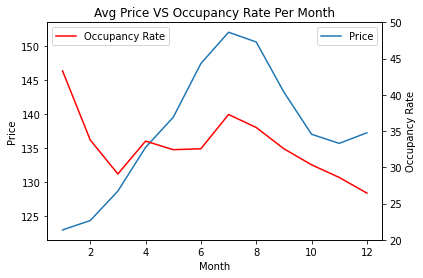

In [12]:
#calculate monthly price and occupancy rate for each listing
#occupancy = occupancy / total_days of each month, formula = occupancy.mean()
#visualize these data points in two lines
cal_groupby = pd.merge(calendar.groupby(['date_month'])['price_cleaned'].mean(),
                       calendar.groupby(['date_month'])['occupancy'].mean()*100, 
                       left_index = True, right_index = True)
#plt.plot(cal_groupby)
fig, ax = plt.subplots()
ax.plot(cal_groupby['price_cleaned'], label='Price')
ax.set_xlabel('Month')
ax.set_ylabel('Price')
ax.legend()

# Get second axis
ax2 = ax.twinx()
ax2.plot(cal_groupby['occupancy'],  label='Occupancy Rate', color = 'r')
ax2.legend(loc='upper left')
ax2.set_ylim(20,50)
ax2.set_ylabel('Occupancy Rate')
plt.title('Avg Price VS Occupancy Rate Per Month')
#The price corresponds to occupancy rate. In summer, the more the rooms are booked ,
#the prices are increased accordingly.
#cal_groupby

# What are the top amenities that are favored by the customers?

In [13]:
#listing exploration
listings.info()
listings.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

(3818, 92)

In [14]:
#Add yearly avg price of each listing to listings dataframe
listing_price = calendar.groupby(['listing_id'])['price_cleaned'].mean()
listings_ad_price = listings.merge(listing_price, how = 'left', left_on='id', right_index = True)
listings_ad_price.info()
#listings_df[['price_cleaned_x']]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 93 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [15]:
#reviews['date'].min(), reviews['date'].max()
#listings_ad_price['review_scores_rating'].mean()
reviews.describe()


,listing_id,id,reviewer_id
count,8.484900e+04,8.484900e+04,8.484900e+04
mean,3.005067e+06,3.058765e+07,1.701301e+07
std,2.472877e+06,1.636613e+07,1.353704e+07
min,4.291000e+03,3.721000e+03,1.500000e+01
25%,7.946330e+05,1.725127e+07,5.053141e+06
50%,2.488228e+06,3.228809e+07,1.413476e+07
75%,4.694479e+06,4.457648e+07,2.762402e+07
max,1.024814e+07,5.873651e+07,5.281274e+07


In [16]:
# create a function that generate a list of strings and its counts
def count_string(df, col):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    col - col contains strings
    
    OUTPUT:
    df - string and its count
    '''
    string_list = dict()
    for n in range(len(df)):
        strings = re.sub('[^a-zA-Z ,]+','',df.iloc[n][col]).split(',')
        for string in strings:
            if string not in string_list:
                string_list[string]=1
            else:
                string_list[string]+=1
    string_series = pd.Series(string_list)
    return string_series


Wireless Internet             1975
Heating                       1949
Kitchen                       1827
Smoke Detector                1794
Essentials                    1768
Dryer                         1595
Washer                        1584
Shampoo                       1540
Internet                      1519
TV                            1419
Carbon Monoxide Detector      1405
Fire Extinguisher             1243
Free Parking on Premises      1218
FamilyKid Friendly            1075
First Aid Kit                  982
Cable TV                       812
Pets live on this property     532
Indoor Fireplace               492
Safety Card                    454
Hangers                        441
Hair Dryer                     417
Elevator in Building           401
Air Conditioning               401
Iron                           398
Laptop Friendly Workspace      390
Hour Checkin                   321
Dogs                           304
BuzzerWireless Intercom        284
Pets Allowed        

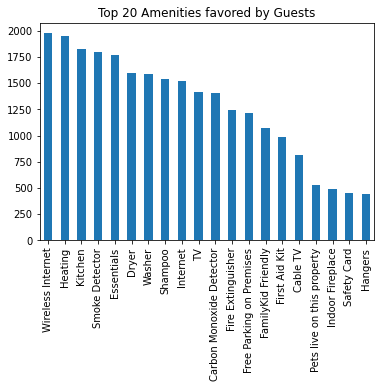

In [17]:
# Determine the listing review is above avg or below average
review_mean = listings['review_scores_rating'].mean()
listings['review_high_low_group'] = listings['review_scores_rating'].apply(lambda x:'high'if x>=review_mean else 'low')
listings[['review_scores_rating','review_high_low_group']].head()
#Amenities, we will only discover the favored amenities for those listings with high reviews
high_review_group = listings[listings['review_high_low_group']=='high'].copy()
type(high_review_group)
count_string(high_review_group,'amenities').sort_values(ascending=False)[0:20].plot(kind='bar')
top_amenities_by_reviews = count_string(high_review_group,'amenities')
plt.title('Top 20 Amenities favored by Guests')

count_string(high_review_group,'amenities').sort_values(ascending=False)

In [18]:
top_20_amenities = top_amenities_by_reviews.sort_values(ascending = False)[:20].index

In [19]:
#data discoveries
amn_list = high_review_group[0:5]
string_list = dict()
for n in range(len(amn_list)):
    strings = re.sub('[^a-zA-Z ,]+','',amn_list['amenities'].iloc[n]).split(',')
    for string in strings:
        
            if string not in string_list:
                string_list[string]=1
            else:
                string_list[string]=+1
string_list
#df = pd.DataFrame(pd.Series(string_list).reset_index())
#df.columns=['amenity','count']
#df

{'TV': 1,
 'Cable TV': 1,
 'Internet': 1,
 'Wireless Internet': 1,
 'Air Conditioning': 1,
 'Kitchen': 1,
 'Heating': 1,
 'FamilyKid Friendly': 1,
 'Washer': 1,
 'Dryer': 1,
 'Free Parking on Premises': 1,
 'BuzzerWireless Intercom': 1,
 'Smoke Detector': 1,
 'Carbon Monoxide Detector': 1,
 'First Aid Kit': 1,
 'Safety Card': 1,
 'Fire Extinguisher': 1,
 'Essentials': 1,
 'Pets Allowed': 1,
 'Pets live on this property': 1,
 'Dogs': 1,
 'Cats': 1,
 'Hot Tub': 1,
 'Indoor Fireplace': 1,
 'Shampoo': 1}

In [20]:
#function to clean comments fields in listings
def parse_comments(df,col):
    
    comment_dict = dict()
    df_nonna = df.dropna(subset=[col])
    for n in range(len(df_nonna)):
        comment_list = re.sub('[^a-zA-Z ]+','',df_nonna.iloc[n][col]).lower().split()
        for c in comment_list:
            if c not in comment_dict:
                comment_dict[c] = 1                
            else:
                comment_dict[c] += 1
                
    comment_series = pd.Series(comment_dict)
    return comment_series

len(parse_comments(reviews, 'comments').sort_values(ascending=False))
        
    

61053

In [21]:
reviews.dropna(subset=['comments'])

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...
...,...,...,...,...,...,...
84844,3624990,50436321,2015-10-12,37419458,Ryan,The description and pictures of the apartment ...
84845,3624990,51024875,2015-10-17,6933252,Linda,We had an excellent stay. It was clean and com...
84846,3624990,51511988,2015-10-20,19543701,Jaime,"Gran ubicación, cerca de todo lo atractivo del..."
84847,3624990,52814482,2015-11-02,24445024,Jørgen,"Very good apartement, clean and well sized. Si..."


In [22]:
listings.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,0.0,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,NaN,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,NaN,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,NaN,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,37.000000,12.150000


In [23]:
listings.select_dtypes(include = ['object']).columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_s

# What are the features that highly influnce the prices? Can we predict the prices based on these features?

In [24]:
cal_cols = listings.select_dtypes(include = ['object']).columns
num_cols = listings.select_dtypes(exclude = ['object']).columns
cal_cols, num_cols

(Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
        'description', 'experiences_offered', 'neighborhood_overview', 'notes',
        'transit', 'thumbnail_url', 'medium_url', 'picture_url',
        'xl_picture_url', 'host_url', 'host_name', 'host_since',
        'host_location', 'host_about', 'host_response_time',
        'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
        'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
        'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
        'street', 'neighbourhood', 'neighbourhood_cleansed',
        'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
        'smart_location', 'country_code', 'country', 'is_location_exact',
        'property_type', 'room_type', 'bed_type', 'amenities', 'price',
        'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
        'extra_people', 'calendar_updated', 'has_availability',
        '

In [25]:
#find what columns null value rate is greater than 0.6
listings.columns[listings.isnull().mean()>0.6]
#drop these columns and create a new listings_cleaned for further pricing prediction analysis
listings_cleaned = listings.drop(['square_feet', 'monthly_price', 'license'], axis = 1).copy()

In [26]:
cal_cols = listings_cleaned.select_dtypes(include = ['object']).columns
num_cols = listings_cleaned.select_dtypes(exclude = ['object']).columns
cal_cols, num_cols

(Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
        'description', 'experiences_offered', 'neighborhood_overview', 'notes',
        'transit', 'thumbnail_url', 'medium_url', 'picture_url',
        'xl_picture_url', 'host_url', 'host_name', 'host_since',
        'host_location', 'host_about', 'host_response_time',
        'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
        'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
        'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
        'street', 'neighbourhood', 'neighbourhood_cleansed',
        'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
        'smart_location', 'country_code', 'country', 'is_location_exact',
        'property_type', 'room_type', 'bed_type', 'amenities', 'price',
        'weekly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
        'calendar_updated', 'has_availability', 'calendar_last_scraped',
 

In [27]:
#reset max columns to show
pd.set_option('display.max_rows', 200)

In [28]:
#convert all price columns to numeric values
clean_price = lambda x: float(re.sub("[^\d\.]",'',x))if not pd.isnull(x) else x #
listings_cleaned[['host_response_rate_cleaned','host_acceptance_rate_cleaned','price_cleaned','weekly_price_cleaned','security_deposit_cleaned','cleaning_fee_cleaned','extra_people_cleaned']]= listings[['host_response_rate','host_acceptance_rate','price',
           'weekly_price','security_deposit','cleaning_fee','extra_people']].applymap(clean_price)

In [29]:
listings_cleaned.shape


(3818, 97)

In [30]:
#select numeric columns names from listings_cleaned dataframe
listings_cleaned.select_dtypes(include=['number']).columns

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'host_response_rate_cleaned',
       'host_acceptance_rate_cleaned', 'price_cleaned', 'weekly_price_cleaned',
       'security_deposit_cleaned', 'cleaning_fee_cleaned',
       'extra_people_cleaned'],
      dtype='object')

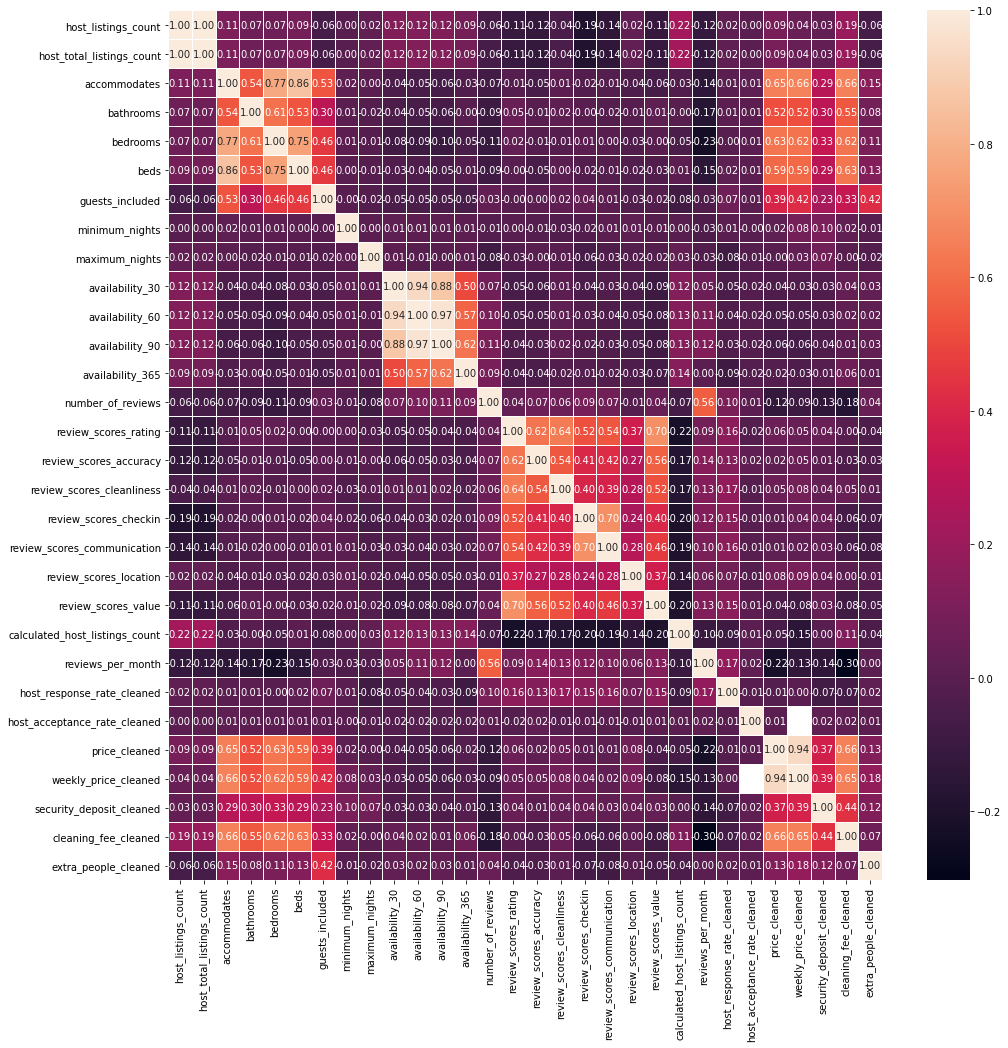

In [31]:
#select numeric column names from listings, 'id', 'scrape_id', 'host_id' exclusive as these columns are identifiers
#generate heatmap for these numeric features
listings_cleaned_col_num = [
    'host_listings_count',
       'host_total_listings_count', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'reviews_per_month', 'host_response_rate_cleaned',
       'host_acceptance_rate_cleaned', 'price_cleaned', 'weekly_price_cleaned',
       'security_deposit_cleaned', 'cleaning_fee_cleaned',
       'extra_people_cleaned'
]
listings_cleaned[listings_cleaned_col_num].corr()['price_cleaned']
plt.figure(figsize=(16,16))
ax = sns.heatmap(listings_cleaned[listings_cleaned_col_num].corr(), annot=True, fmt=".2f", linewidths=.5)
#it looks like price highly correlates with those numeric fields
#accommodates, bathrooms, bedrooms,beds, security_deposit_cleaned,cleaning_fee_cleaned 

In [32]:
#cleanse categorical data in listings_cleaned dataframe
listings_cleaned_col_cat = listings_cleaned.select_dtypes(include=['object']).columns
listings_cleaned[listings_cleaned_col_cat].iloc[0]

listing_url                                       https://www.airbnb.com/rooms/241032
last_scraped                                                               2016-01-04
name                                                     Stylish Queen Anne Apartment
summary                                                                           NaN
space                               Make your self at home in this charming one-be...
description                         Make your self at home in this charming one-be...
experiences_offered                                                              none
neighborhood_overview                                                             NaN
notes                                                                             NaN
transit                                                                           NaN
thumbnail_url                                                                     NaN
medium_url                                            

In [33]:
#looking at these categorical columns, interested in transforming hosting_since to a field describing how many years 
# the property is hosting.
listings_cleaned['host_since_cleaned'] = abs(pd.to_datetime(listings_cleaned['host_since'], format="%Y-%m-%d").apply(lambda x:x.year)-datetime.date.today().year)
listings_cleaned['last_review_cleaned'] = abs(pd.to_datetime(listings_cleaned['last_review'], format="%Y-%m-%d").apply(lambda x:x.year)-datetime.date.today().year)
listings_cleaned[['host_since_cleaned','last_review_cleaned','price_cleaned']].corr()
#last_review & host_since doesn't have high corr with price

,host_since_cleaned,last_review_cleaned,price_cleaned
host_since_cleaned,1.000000,0.127757,0.050834
last_review_cleaned,0.127757,1.000000,0.047280
price_cleaned,0.050834,0.047280,1.000000


In [34]:
#as this data is airbnb hostings in seattle, we can drop some fields which don't have much variations
listings_cleaned[['market','country_code','city','smart_location','jurisdiction_names']].value_counts()
listings_cleaned[[#'neighbourhood','neighbourhood_cleansed',
                  'neighbourhood_group_cleansed']].value_counts()

neighbourhood_group_cleansed
Other neighborhoods             794
Capitol Hill                    567
Downtown                        530
Central Area                    369
Queen Anne                      295
Ballard                         230
West Seattle                    203
Rainier Valley                  159
University District             122
Beacon Hill                     118
Cascade                          89
Northgate                        80
Delridge                         79
Lake City                        67
Magnolia                         61
Seward Park                      44
Interbay                         11
dtype: int64

In [35]:
# to get a final list of categorical fields
# host_neighbor, neighbourhood_group_cleanse is describing similar information,
listings_cleaned_col_cat = [
  'host_is_superhost', 'host_has_profile_pic','neighbourhood_group_cleansed', 
    'property_type','room_type','bed_type','review_high_low_group']
listings_cleaned['host_has_profile_pic'].value_counts(dropna=False)
#since host_has_profile_pic,host_is_superhost has only two nan values, dummyna is set false
listings_cleaned_fin = create_dummy_df(listings_cleaned, listings_cleaned_col_cat, False)

In [36]:
#based on correclation of numeric columns and discovery work on categorical columns, choose the following attribute 
# to build prediction models
cols = ['bathrooms', 'bedrooms','beds', 'security_deposit_cleaned','cleaning_fee_cleaned','price_cleaned',
        'host_is_superhost_t', 'host_has_profile_pic_t',
       'neighbourhood_group_cleansed_Beacon Hill',
       'neighbourhood_group_cleansed_Capitol Hill',
       'neighbourhood_group_cleansed_Cascade',
       'neighbourhood_group_cleansed_Central Area',
       'neighbourhood_group_cleansed_Delridge',
       'neighbourhood_group_cleansed_Downtown',
       'neighbourhood_group_cleansed_Interbay',
       'neighbourhood_group_cleansed_Lake City',
       'neighbourhood_group_cleansed_Magnolia',
       'neighbourhood_group_cleansed_Northgate',
       'neighbourhood_group_cleansed_Other neighborhoods',
       'neighbourhood_group_cleansed_Queen Anne',
       'neighbourhood_group_cleansed_Rainier Valley',
       'neighbourhood_group_cleansed_Seward Park',
       'neighbourhood_group_cleansed_University District',
       'neighbourhood_group_cleansed_West Seattle',
       'property_type_Bed & Breakfast', 'property_type_Boat',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Dorm',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Tent', 'property_type_Townhouse',
       'property_type_Treehouse', 'property_type_Yurt',
      'room_type_Private room', 'room_type_Shared room', 'bed_type_Couch']
       #'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed']
       #'review_high_low_group_low']

listings_pred_finalized = listings_cleaned_fin[cols]

In [37]:
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(listings_pred_finalized, 'price_cleaned')

In [55]:
#define coefficiency model to look at what attributes have larger impact on the model.
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
66,property_type_Boat,125.412655,125.412655
81,room_type_Shared room,-78.622227,78.622227
69,property_type_Camper/RV,58.551476,58.551476
80,room_type_Private room,-41.253056,41.253056
57,neighbourhood_group_cleansed_Magnolia,36.022100,36.022100
76,property_type_Tent,-32.119510,32.119510
51,neighbourhood_group_cleansed_Cascade,30.668396,30.668396
1,bedrooms,30.334223,30.334223
54,neighbourhood_group_cleansed_Downtown,29.925906,29.925906
44,Doorman,29.664816,29.664816


In [38]:
test_score, train_score
#the best score achieved is rscore 60% still quite some to improve

(0.5984714787905506, 0.5852740048502504)

In [39]:
listings_cleaned.columns[20:150]

Index(['host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'weekly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights', 'calendar_updated',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'calendar_last_scraped',
  

In [40]:
# create a function that generate dummy data for a series of lists
def amenities_data(df, col, num):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    col - col contains strings
    num - top n amenities that the high reviews listings have in common
    
    OUTPUT:
    df - new df using top n amenities to create dummy data and append to df
    '''
    string_list = dict()
    #convert amenities to a series of lists
    df_new = df.copy()
    df_new[col] = df[col].apply(lambda x: re.sub('[^a-zA-Z ,]+','',x).split(',') if x is not np.nan else x)
    #Get top n amenities
    for n in range(len(df)):
        str_l = df_new[col][n]
        for n in range(len(str_l)):
            if str_l[n] not in string_list:
                string_list[str_l[n]]=1
            else:
                string_list[str_l[n]]+=1
    string_series = pd.Series(string_list)
    top_n_cols = string_series.sort_values(ascending=False)[:num].index #top n items from the sring
    
    #cleanse amenities columns to replace it with a list of amenities
    df_new[top_n_cols] = 0
    # determine whether this amenities is existing in amenities columns
    for c in top_n_cols:
        df_new[c] = df_new[col].apply(lambda x: 1 if c in x else 0)
    
    return df_new


In [41]:
#create new df with amenities_data function
amenities_data(listings_cleaned, 'amenities', 15)
listings_cleaned_amenities = amenities_data(listings_cleaned, 'amenities', 42) # max 42 amenities
listings_cleaned_amenities.columns[20:200]
listings_cleaned_col_cat = [
  'host_is_superhost', 'host_has_profile_pic','neighbourhood_group_cleansed', 
    'property_type','room_type','bed_type','review_high_low_group']
listings_cleaned['host_has_profile_pic'].value_counts(dropna=False)
#since host_has_profile_pic,host_is_superhost has only two nan values, dummyna is set false
listings_cleaned_fin = create_dummy_df(listings_cleaned_amenities, listings_cleaned_col_cat, False)
listings_cleaned_fin.columns[50:150]

Index(['price', 'weekly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'calendar_last_scraped', 'number_of_reviews', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'jurisdiction_names',
       'instant_bookable', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month',
       'host_response_rate_cleaned', 'host_acceptance_rate_cleaned',
       'price_cleaned', 'weekly_price_cleaned', 'security_deposit_cleaned',
       'cleaning_fee_cleaned', 'extra_people_cleaned

In [42]:
#use the columns in the last prediction plus the ameninties to make predictions
cols = ['bathrooms', 'bedrooms','beds', 'cleaning_fee_cleaned','price_cleaned','security_deposit_cleaned',
        'host_is_superhost_t', 'host_has_profile_pic_t',
        'Wireless Internet', 'Heating', 'Kitchen',
       'Smoke Detector', 'Essentials', 'Dryer', 'Washer', 'Internet',
       'Shampoo', 'TV', 'Carbon Monoxide Detector', 'Fire Extinguisher',
       'Free Parking on Premises', 'FamilyKid Friendly', 'First Aid Kit',
       'Cable TV', 'Indoor Fireplace', 'Pets live on this property', 'Hangers',
       'Elevator in Building', 'Hair Dryer', 'Laptop Friendly Workspace',
       'Iron', 'Safety Card', 'Air Conditioning', 'Hour Checkin',
       'BuzzerWireless Intercom', 'Dogs', 'Pets Allowed', 'Gym', 'Cats',
       'Hot Tub', 'Wheelchair Accessible', 'Breakfast', 'Suitable for Events',
       'Pool', 'Lock on Bedroom Door', 'Doorman', 'Smoking Allowed',
       'Other pets', '', 'Washer  Dryer',
       'neighbourhood_group_cleansed_Beacon Hill',
       'neighbourhood_group_cleansed_Capitol Hill',
       'neighbourhood_group_cleansed_Cascade',
       'neighbourhood_group_cleansed_Central Area',
       'neighbourhood_group_cleansed_Delridge',
       'neighbourhood_group_cleansed_Downtown',
       'neighbourhood_group_cleansed_Interbay',
       'neighbourhood_group_cleansed_Lake City',
       'neighbourhood_group_cleansed_Magnolia',
       'neighbourhood_group_cleansed_Northgate',
       'neighbourhood_group_cleansed_Other neighborhoods',
       'neighbourhood_group_cleansed_Queen Anne',
       'neighbourhood_group_cleansed_Rainier Valley',
       'neighbourhood_group_cleansed_Seward Park',
       'neighbourhood_group_cleansed_University District',
       'neighbourhood_group_cleansed_West Seattle',
       'property_type_Bed & Breakfast', 'property_type_Boat',
       'property_type_Bungalow', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Dorm',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Tent', 'property_type_Townhouse',
       'property_type_Treehouse', 'property_type_Yurt',
      'room_type_Private room', 'room_type_Shared room', 'bed_type_Couch']
      # 'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed',
       #'review_high_low_group_low']

listings_pred_finalized = listings_cleaned_fin[cols]

In [43]:
#make predictions using new col list
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(listings_pred_finalized, 'price_cleaned')

In [44]:
#increase amenities from top 15 to top 20, test score performance better from 0.5971 to 0.600034
#use total 42 amenities
#if use mean to fill numeric columns, the best performance is 60.3%
test_score, train_score

(0.6032167961913802, 0.6007396208277014)

# What neighbors have top reviews? What common features do they have?

In [45]:
listings['review_scores_rating'].describe()
#create a dataframe to discover reviews data
#listings_reviews = listings.dropna(subset=['review_scores_rating'])
#listings_reviews['review_scores_rating'].describe(), listings_reviews.shape

count    3171.000000
mean       94.539262
std         6.606083
min        20.000000
25%        93.000000
50%        96.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

Text(0.5, 1.0, 'Number of listings in Each Neighbourhood')

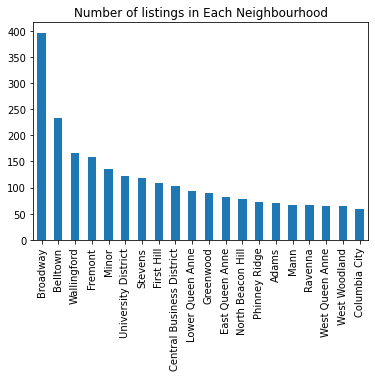

In [46]:
#Number of listings in Each Neighbourhood
#listings_reviews[['neighborhood_overview','amenities','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed']].head(1)
#print(listings[['neighbourhood_group_cleansed']].value_counts())
#listings['neighbourhood_group_cleansed'].value_counts().plot(kind = 'bar')
listings['neighbourhood_cleansed'].value_counts().sort_values(ascending=False)[:20].plot(kind = 'bar')
plt.title('Number of listings in Each Neighbourhood')

In [47]:
#create a dataframe only show avg_reviews & total listings
neighbourhood_avg_reviews = listings.groupby(['neighbourhood_cleansed'])['review_scores_rating'].mean().sort_values(ascending = False)
neighbourhood_listings_reviews = (listings.groupby('neighbourhood_cleansed').agg({'review_scores_rating':'mean', 
                         'id':'count', 
                         }))
neighbourhood_listings_reviews = neighbourhood_listings_reviews.rename(columns={"review_scores_rating": "avg_review_rating", "id": "count_of_listings"})
neighbourhood_listings_reviews.reset_index(inplace = True)
neighbourhood_listings_reviews=neighbourhood_listings_reviews.rename(columns={"index":'neighbourhood_cleansed'})
neighbourhood_listings_reviews=neighbourhood_listings_reviews.sort_values(by='avg_review_rating', ascending = False)
avg_review = neighbourhood_listings_reviews['avg_review_rating'].mean()
neighbourhood_listings_reviews['above_avg_review']=neighbourhood_listings_reviews['avg_review_rating'].apply(lambda x:'high'if x > avg_review else 'low' )
                                                                    

In [48]:
neighbourhood_listings_reviews, neighbourhood_listings_reviews.shape

(       neighbourhood_cleansed  avg_review_rating  count_of_listings  \
 2               Arbor Heights          98.000000                  5   
 64                  Riverview          97.250000                  8   
 73         Southeast Magnolia          97.214286                 17   
 41                    Madrona          97.100000                 47   
 28      Harrison/Denny-Blaine          97.083333                 14   
 23                    Genesee          96.933333                 34   
 51     North Beach/Blue Ridge          96.909091                 14   
 35                Laurelhurst          96.777778                 10   
 84           Whittier Heights          96.666667                 26   
 54             North Delridge          96.600000                 32   
 83                   Westlake          96.500000                 17   
 53         North College Park          96.428571                 19   
 85                 Windermere          96.375000               

In [64]:
neighbourhood_listings_reviews_top_40 = neighbourhood_listings_reviews.iloc[:60,:]
neighbourhood_listings_reviews_top_40.reset_index(drop=True)

,neighbourhood_cleansed,avg_review_rating,count_of_listings,above_avg_review
0,Arbor Heights,98.000000,5,high
1,Riverview,97.250000,8,high
2,Southeast Magnolia,97.214286,17,high
3,Madrona,97.100000,47,high
4,Harrison/Denny-Blaine,97.083333,14,high
5,Genesee,96.933333,34,high
6,North Beach/Blue Ridge,96.909091,14,high
7,Laurelhurst,96.777778,10,high
8,Whittier Heights,96.666667,26,high
9,North Delridge,96.600000,32,high


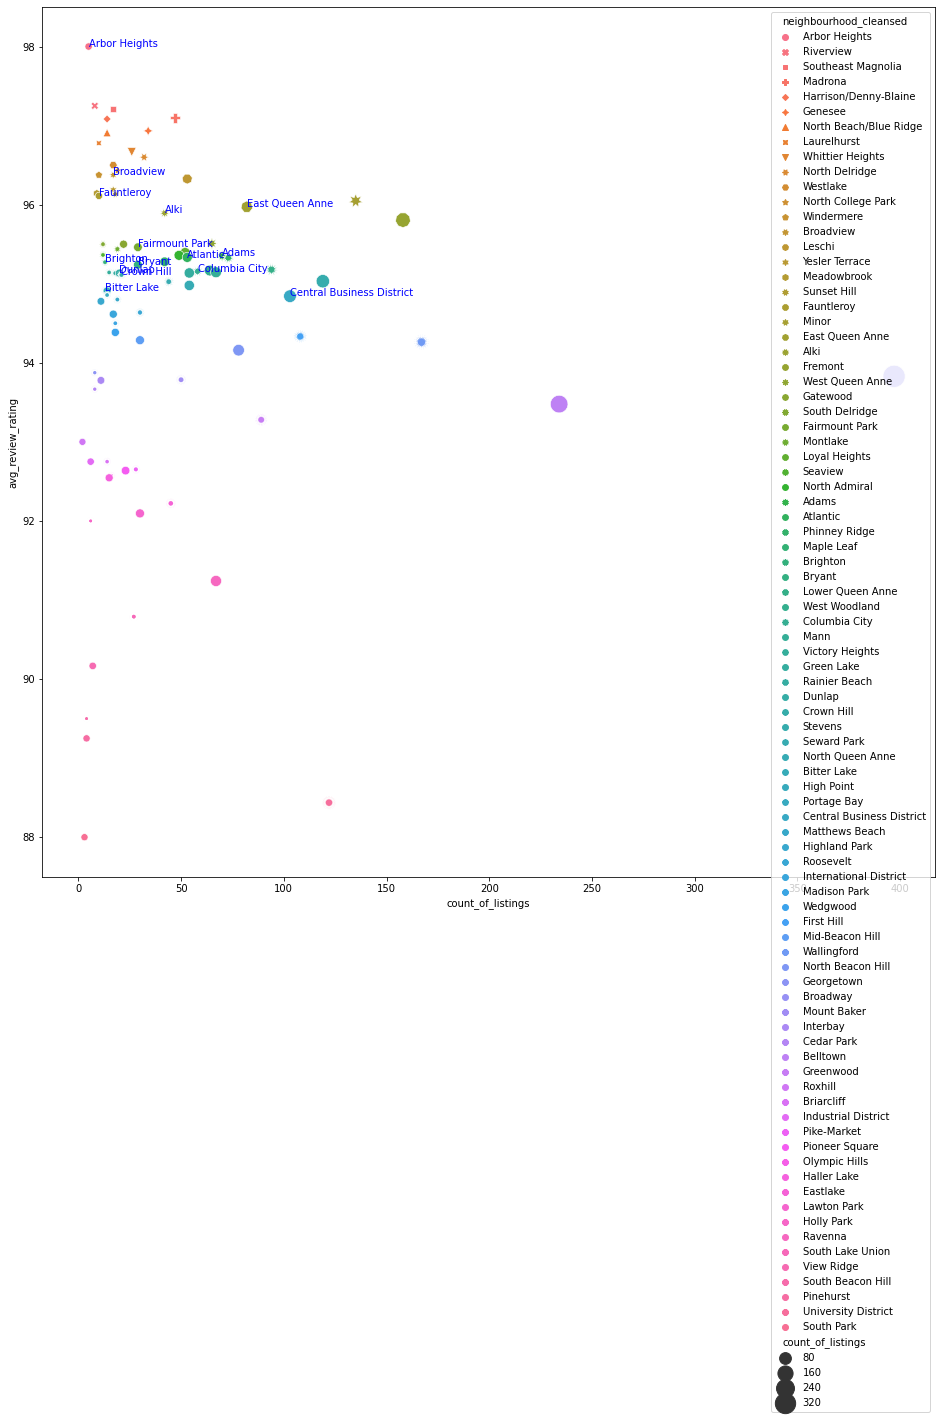

In [50]:
#All neighbours reviews and 
plt.figure(figsize=(16,16))
ax = sns.scatterplot(data=neighbourhood_listings_reviews, 
                x="count_of_listings", y="avg_review_rating", size= "count_of_listings"
                ,hue="neighbourhood_cleansed", style = 'neighbourhood_cleansed', sizes=(50, 500))
for n in range(20):
    if neighbourhood_listings_reviews.above_avg_review[n]=='high':
        plt.text(neighbourhood_listings_reviews.count_of_listings[neighbourhood_listings_reviews.neighbourhood_cleansed==neighbourhood_listings_reviews.neighbourhood_cleansed[n]],neighbourhood_listings_reviews.avg_review_rating[neighbourhood_listings_reviews.neighbourhood_cleansed==neighbourhood_listings_reviews.neighbourhood_cleansed[n]],neighbourhood_listings_reviews.neighbourhood_cleansed[n], color='blue')
    
        #df.G[df.Team=='TOT'],df.GA[df.Team=='TOT']
#plt.text(neighbourhood_listings_reviews.count_of_listings[neighbourhood_listings_reviews.above_avg_review=='high'],neighbourhood_listings_reviews.avg_review_rating[neighbourhood_listings_reviews.above_avg_review=='high'],neighbourhood_listings_reviews['neighbourhood_cleansed'], color='red')
plt.show()

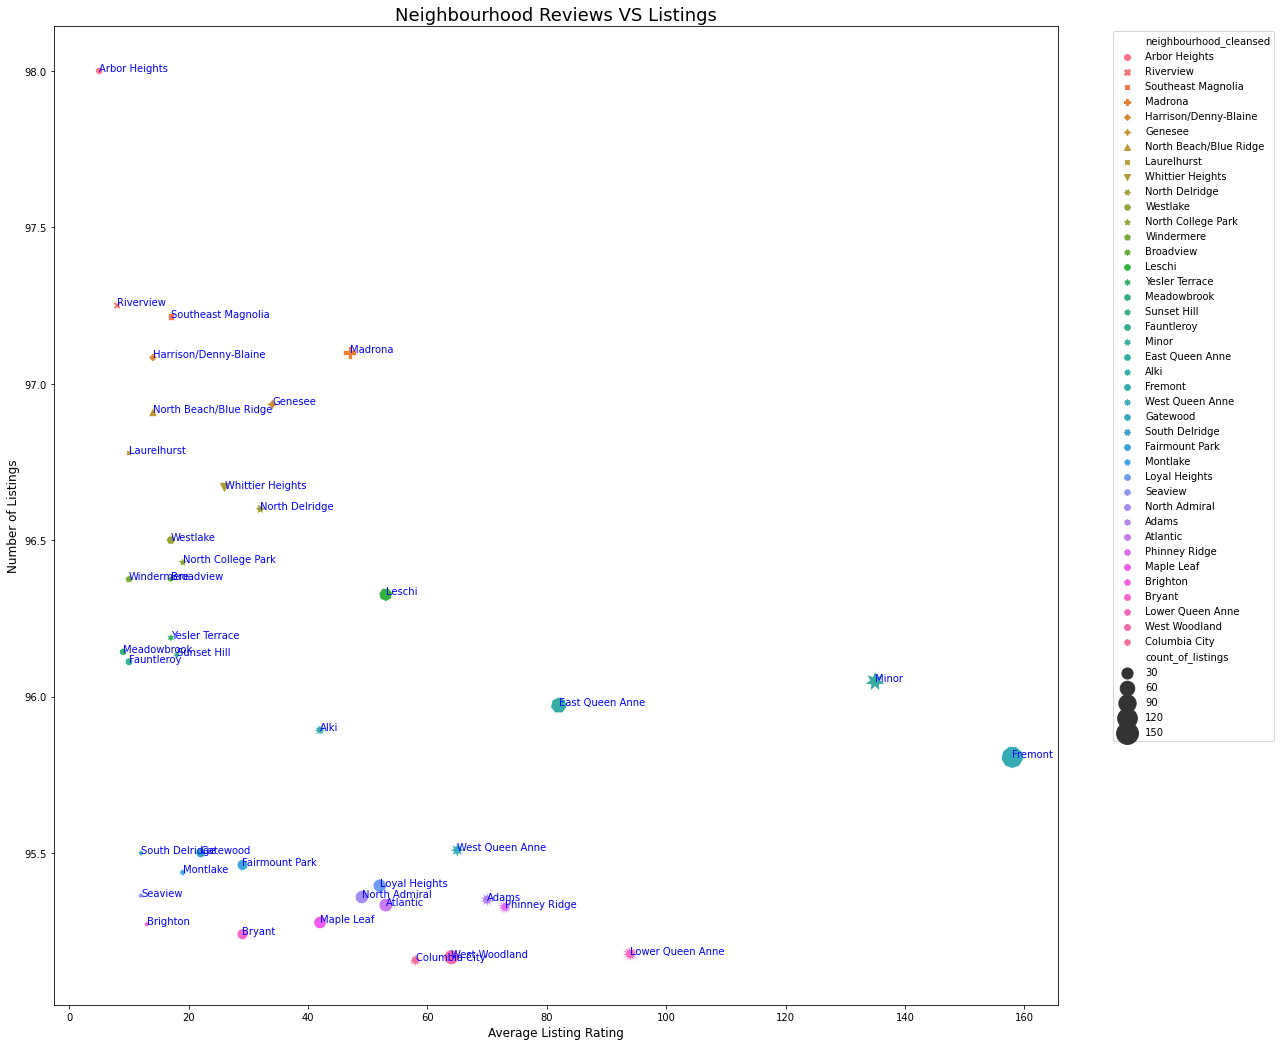

In [96]:
#define a function that plot neighbourhood reviews and listings
def clean_and_plot(df, n,title='Neighbourhood Reviews VS Listings', plot=True):
    '''
    INPUT 
        df - a dataframe 
        title - string the title of your plot
        n - number of listings to plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    neighbourhood_avg_reviews = df.groupby(['neighbourhood_cleansed'])['review_scores_rating'].mean().sort_values(ascending = False)
    neighbourhood_listings_reviews = (df.groupby('neighbourhood_cleansed').agg({'review_scores_rating':'mean', 
                         'id':'count', 
                         }))
    neighbourhood_listings_reviews = neighbourhood_listings_reviews.rename(columns={"review_scores_rating": "avg_review_rating", "id": "count_of_listings"})
    neighbourhood_listings_reviews.reset_index(inplace = True)
    neighbourhood_listings_reviews=neighbourhood_listings_reviews.rename(columns={"index":'neighbourhood_cleansed'})
    neighbourhood_listings_reviews=neighbourhood_listings_reviews.sort_values(by='avg_review_rating', ascending = False)
    avg_review = neighbourhood_listings_reviews['avg_review_rating'].mean()
    neighbourhood_listings_reviews['above_avg_review']=neighbourhood_listings_reviews['avg_review_rating'].apply(lambda x:'high'if x > avg_review else 'low' )
    neighbourhood_listings_reviews_top_n = neighbourhood_listings_reviews.iloc[:n,:].reset_index(drop=True)
                                                               
    if plot:
        plt.figure(figsize=(18,18))
        ax = sns.scatterplot(data=neighbourhood_listings_reviews_top_n, 
                x="count_of_listings", y="avg_review_rating", size= "count_of_listings"
                ,hue="neighbourhood_cleansed", style = 'neighbourhood_cleansed', sizes=(50, 500))
        for n in range(n):
            if neighbourhood_listings_reviews_top_n.above_avg_review[n]=='high':
               
                plt.text(neighbourhood_listings_reviews_top_n.count_of_listings[neighbourhood_listings_reviews_top_n.neighbourhood_cleansed==neighbourhood_listings_reviews_top_n.neighbourhood_cleansed[n]],neighbourhood_listings_reviews_top_n.avg_review_rating[neighbourhood_listings_reviews_top_n.neighbourhood_cleansed==neighbourhood_listings_reviews_top_n.neighbourhood_cleansed[n]],neighbourhood_listings_reviews_top_n.neighbourhood_cleansed[n], color='blue')
        plt.title(title)
        plt.legend(#labels=['Neighbourhood', 'Count of Listings'], title='title',
                   bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.title(title, fontsize=18)
        plt.xlabel('Average Listing Rating', fontsize=12)
        plt.ylabel('Number of Listings',  fontsize=12)
        plt.show()
    return neighbourhood_listings_reviews, neighbourhood_listings_reviews_top_n
    
props_df, props_df_top_n = clean_and_plot(listings, 40)



In [78]:
props_df

,neighbourhood_cleansed,avg_review_rating,count_of_listings,above_avg_review
2,Arbor Heights,98.000000,5,high
64,Riverview,97.250000,8,high
73,Southeast Magnolia,97.214286,17,high
41,Madrona,97.100000,47,high
28,Harrison/Denny-Blaine,97.083333,14,high
23,Genesee,96.933333,34,high
51,North Beach/Blue Ridge,96.909091,14,high
35,Laurelhurst,96.777778,10,high
84,Whittier Heights,96.666667,26,high
54,North Delridge,96.600000,32,high


Text(0.5, 1.0, 'Property Type Distributions for Neighbourhood with High Reviews')

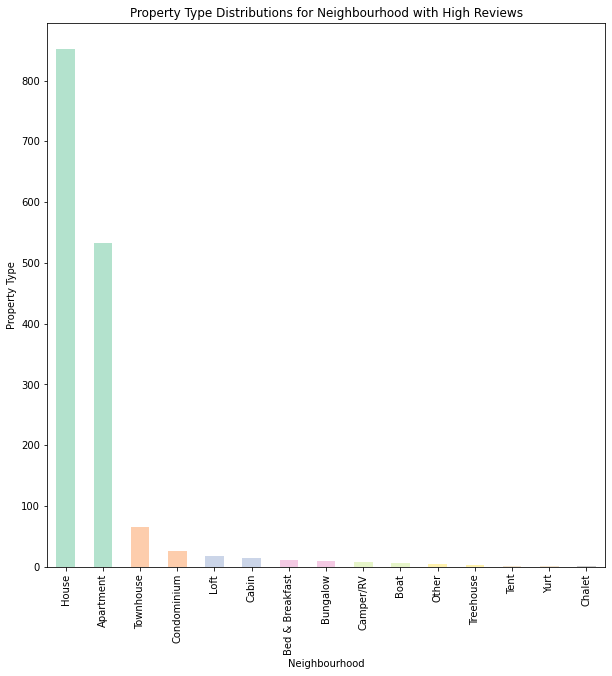

In [124]:
#Take a look at listings description
listings_high_reviews_property = listings.property_type[listings.neighbourhood_cleansed.isin(
    props_df_top_n['neighbourhood_cleansed'].tolist())].value_counts().sort_values(ascending = False)
#listings_high_reviews_property = listings_high_reviews_property.rename(columns = {'index':'property_type', 'property_type': 'count'})

plt.figure(figsize=(10,10))

data = range(len(listings_high_reviews_property))
# Get a color map
my_cmap = cm.get_cmap('Pastel2')
 
# Get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(0, len(data))

listings_high_reviews_property.plot(kind='bar', color=my_cmap(my_norm(data)))
plt.xlabel('Neighbourhood')
plt.ylabel('Property Type')


plt.title('Property Type Distributions for Neighbourhood with High Reviews')
#plt.plot(listings_high_reviews_property['property_type'], listings_high_reviews_property['count'], color = 'yellow')
